In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import utils
from mdl import torch as mdl

ml_data shape: (100000, 4)


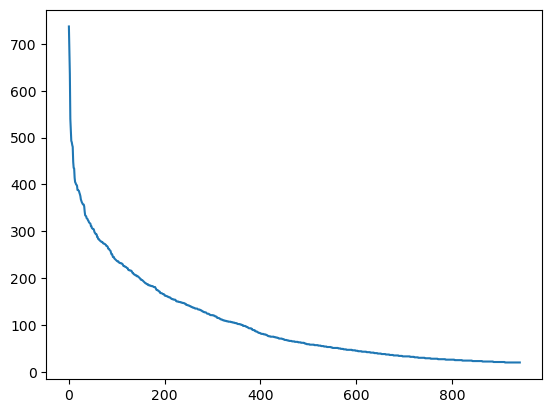

In [3]:
def read_data_ml100k():
    mdl.DATA_HUB['ml-100k'] = (
        'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
        'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')
    ml_data_dir = mdl.download_extract('ml-100k')
    ml_data = pd.read_csv(os.path.join(ml_data_dir, 'u.data'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    print(f'ml_data shape: {ml_data.shape}')
    ml_data_num_users = ml_data.user_id.unique().shape[0]
    ml_data_num_items = ml_data.item_id.unique().shape[0]
    return ml_data, ml_data_num_users, ml_data_num_items

ml_data, ml_data_num_users, ml_data_num_items = read_data_ml100k()
vc = ml_data.user_id.value_counts()
vc.reset_index(drop=True).plot()

def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data


In [214]:
td = split_data_ml100k(ml_data, ml_data_num_users, ml_data_num_items, 'seq-aware')[0]
uir_tensors = torch.tensor(td.values[:, (0,1,2)])
train_batches = utils.data.DataLoader(utils.data.TensorDataset(uir_tensors[:,0], uir_tensors[:,1], uir_tensors[:,2].float()), batch_size=100, shuffle=True)
u, i, v = next(iter(train_batches))
u, i, v, uir_tensors.shape
# len(ml_data.user_id.unique()), ml_data.user_id.unique().max()
td, ml_data_num_users, ml_data_num_items

(         0    1  2          3
 0        1  168  5  874965478
 1        1  172  5  874965478
 2        1  165  5  874965518
 3        1  156  4  874965556
 4        1  196  5  874965677
 ...    ...  ... ..        ...
 99052  943  227  1  888693158
 99053  943  449  1  888693158
 99054  943  229  2  888693158
 99055  943  230  1  888693158
 99056  943  228  3  888693158
 
 [99057 rows x 4 columns],
 943,
 1682)

In [5]:
import math
from tqdm import tqdm, trange

hidden_dim = 128

class MF(nn.Module):
    def __init__(self):
        super().__init__()
        self.u_embed = nn.Embedding(1000, hidden_dim)
        self.i_embed = nn.Embedding(2000, hidden_dim)
        self.u_bias = nn.Embedding(1000, 1)
        self.i_bias = nn.Embedding(2000, 1)
        self.loss = nn.MSELoss()
    def forward(self, u, i):
        return (self.u_embed(u) * self.i_embed(i)).sum(axis=1) + self.u_bias(u).squeeze() + self.i_bias(i).squeeze()
    def get_loss(self, u, i, r):
        return self.loss(self(u, i), r)

epoch_num = 3
model = MF()
optim = torch.optim.SGD(model.parameters(), lr=0.001)
for epoch in range(epoch_num):
    loss_val, count = .0, 0
    for u, i, r in train_batches:
        loss = model.get_loss(u, i, r)
        loss_val += loss
        count += 1
        optim.zero_grad()
        loss.backward()
        optim.step()
    loss_val /= count
    rmse = math.sqrt(loss_val)
    print(f'[epoch-{epoch}]  loss-val: {loss_val} rmse: {rmse}')

[epoch-0]  loss-val: 141.88912963867188 rmse: 11.911722362390414
[epoch-1]  loss-val: 138.61195373535156 rmse: 11.773357793567287
[epoch-2]  loss-val: 135.45086669921875 rmse: 11.638336079492582


In [230]:
import random
from mdl import torch as mdl

class Ml100kData(mdl.DataModule):
    def __init__(self, seq_aware=False, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        ml_data, self.num_users, self.num_items = self.read_data_ml100k()
        train_data, test_data = self.split_data_ml100k(ml_data, self.num_users, self.num_items,
                                                       'seq-aware' if seq_aware else 'random')
        if seq_aware:
            self.train_dataset, self.test_dataset = train_data, test_data
            self.train_loader = torch.utils.data.DataLoader(self.train_dataset, self.batch_size, shuffle=True)
            self.test_loader = torch.utils.data.DataLoader(self.test_dataset, self.batch_size, shuffle=False)
        else:
            train_uir= torch.tensor(train_data.values[:, (0,1,2)])
            test_uir= torch.tensor(test_data.values[:, (0,1,2)])
            self.train_loader = self.get_tensorloader((train_uir[:,0], train_uir[:,1], train_uir[:,2].float()), True)
            self.test_loader = self.get_tensorloader((test_uir[:,0], test_uir[:,1], test_uir[:,2].float()), False)
    def get_dataloader(self, train):
        return self.train_loader if train else self.test_loader
        # if train:
        #     return self.get_tensorloader((self.train_uir[:,0], self.train_uir[:,1], self.train_uir[:,2].float()), train)
        # else:
        #     return self.get_tensorloader((self.test_uir[:,0], self.test_uir[:,1], self.test_uir[:,2].float()), train)
    def read_data_ml100k(self):
        mdl.DATA_HUB['ml-100k'] = (
            'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
            'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')
        ml_data_dir = mdl.download_extract('ml-100k')
        ml_data = pd.read_csv(os.path.join(ml_data_dir, 'u.data'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
        print(f'ml_data shape: {ml_data.shape}')
        ml_data_num_users = ml_data.user_id.unique().shape[0]
        ml_data_num_items = ml_data.item_id.unique().shape[0]
        return ml_data, ml_data_num_users, ml_data_num_items
    def split_data_ml100k(self, data, num_users, num_items,
                          split_mode='random', test_ratio=0.1):
        """Split the dataset in random mode or seq-aware mode."""
        if split_mode == 'seq-aware':
            user_history, sorted_list = {}, []
            for line in data.itertuples():
                u, i, rating, time = line[1], line[2], line[3], line[4]
                user_history.setdefault(u, []).append((u, i, rating, time))
            for u in range(1, num_users + 1):
                sorted_list.extend(sorted(user_history[u], key=lambda k: k[3]))
            sorted_df = pd.DataFrame(sorted_list, columns=['uid', 'iid', 'rating', 'time'])
            user_items = {u:[i for _,i,_,_ in l] for u,l in user_history.items()}
            # print(f'zero uid df: {sorted_df[sorted_df.uid == 0]}')
            builder = SeqDatasetBuilder(sorted_df.uid.to_numpy(), sorted_df.iid.to_numpy(), 
                                        5, self.num_users, self.num_items, user_items)
            train_data, test_data = builder.build(True), builder.build(False)
        else:
            mask = [True if x == 1 else False for x in np.random.uniform(
                0, 1, (len(data))) < 1 - test_ratio]
            neg_mask = [not x for x in mask]
            train_data, test_data = data[mask], data[neg_mask]
        return train_data, test_data

class SeqDatasetBuilder:
    def __init__(self, user_ids, item_ids, L, num_users, num_items,
                 candidates):
        # 下面有些排序操作有些冗余，先这样
        # 将 user_ids 和 item_ids 转换为 numpy 数组，便于操作
        user_ids, item_ids = np.array(user_ids), np.array(item_ids)
        # 根据 user_ids 对 user_ids 和 item_ids 进行排序，以保持用户交互的顺序
        sort_idx = np.array(sorted(range(len(user_ids)),
                                   key=lambda k: user_ids[k]))
        u_ids, i_ids = user_ids[sort_idx], item_ids[sort_idx]
        # 创建一个字典来存储每个用户交互的物品
        temp, u_ids, self.cand = {}, u_ids, candidates
        self.all_items = set([i+1 for i in range(num_items)])  # 所有物品的索引集合
        # 填充 temp 字典，键是 user_id，值是物品索引列表
        [temp.setdefault(u_ids[i], []).append(i) for i, _ in enumerate(u_ids)]
        # 按 user_id 对 temp 字典进行排序，以保持一致的顺序
        temp = sorted(temp.items(), key=lambda x: x[0])
        u_ids = np.array([i[0] for i in temp])  # 提取排序后的用户 ID
        idx = np.array([i[1][0] for i in temp])  # 提取每个用户交互的起始索引
        # 计算所有用户的有效序列数量
        self.ns = ns = int(sum([(c - L if c >= L + 1 else 1) - 1 for c
                                in np.array([len(i[1]) for i in temp])]))
        # 初始化数组来存储序列、用户和目标
        self.seq_items = np.zeros((ns, L), dtype='int32')  # 用户的交互历史序列
        self.seq_users = np.zeros(ns, dtype='int32')  # 每个序列对应的用户 ID
        self.seq_tgt = np.zeros(ns, dtype='int32')  # 要预测的目标物品
        self.test_seq_items = np.zeros((num_users, L), dtype='int32')  # 每个用户的测试序列
        self.test_seq_users, _uid = np.zeros(num_users, dtype='int32'), None
        self.test_seq_tgt = np.zeros(ns, dtype='int32')
        # 遍历用户序列，创建训练和测试数据
        last = 0
        for i, (uid, i_seq) in enumerate(self._seq(u_ids, i_ids, idx, L + 1)):
            if uid != _uid:
                # 存储每个用户序列中的最后 L 个物品用于测试
                self.test_seq_tgt[uid - 1] = i_seq[-1]
                self.test_seq_items[uid - 1][:] = i_seq[:L]
                self.test_seq_users[uid - 1], _uid = uid, uid
            else:
                # 存储目标物品和用户的最后 L 个物品序列
                self.seq_tgt[last] = i_seq[-1]
                self.seq_items[last][:] = i_seq[:L]
                self.seq_users[last] = uid
                last += 1
    # 滑动窗口生成器，用于从序列中创建固定大小的窗口
    def _win(self, tensor, window_size, step_size=1):
        # 使用滑动窗口从末尾到开头遍历序列
        if len(tensor) - window_size >= 0:
            for i in range(len(tensor), 0, - step_size):
                if i - window_size >= 0:
                    yield tensor[i - window_size:i]
                else:
                    break
        else:
            yield tensor  # 如果序列长度小于窗口大小，返回整个序列
    # 为每个用户生成序列，生成长度最多为 max_len 的序列
    def _seq(self, u_ids, i_ids, idx, max_len):
        for i in range(len(idx)):
            # 确定当前用户的停止索引
            stop_idx = None if i >= len(idx) - 1 else int(idx[i + 1])
            # 使用滑动窗口为当前用户生成序列
            for s in self._win(i_ids[int(idx[i]):stop_idx], max_len):
                yield (int(u_ids[i]), s)
    def build(self, train=True):
        if train:
            return SeqDataset(self.seq_users, self.seq_items, self.seq_tgt, self.cand, self.all_items)
        else:
            return SeqDataset(self.test_seq_users, self.test_seq_items, self.test_seq_tgt, self.cand, self.all_items)

class SeqDataset:
    # 返回数据集中可用的序列数量
    def __init__(self, seq_users, seq_items, seq_tgt, cand, all_items):
        self.seq_users = seq_users
        self.seq_items = seq_items
        self.seq_tgt = seq_tgt
        self.cand = cand
        self.all_items = all_items
    def __len__(self):
        return self.seq_users.shape[0]
    # 从数据集中获取特定的序列，包括负采样
    def __getitem__(self, idx):
        # 负采样：找到用户未交互的物品
        neg = list(self.all_items - set(self.cand[int(self.seq_users[idx])]))
        i = random.randint(0, len(neg) - 1)  # 随机选择一个负样本
        # 返回用户 ID、物品序列、目标物品和负样本
        return (self.seq_users[idx], self.seq_items[idx], self.seq_tgt[idx],
                neg[i])

class Regression(mdl.Module):
    def __init__(self, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        l = self.loss(Y_hat, batch[-1])
        acc = (torch.abs(Y_hat - batch[-1]) <= 0.5).float().mean()
        self.plot('loss', l, train=False)
        self.plot('rmse', torch.sqrt(l), train=False)
        self.plot('acc', acc, train=False)
    def loss(self, y_hat, y, averaged=True):
        fn = nn.MSELoss()
        return fn(y_hat, y)

class Lable10Classifier(mdl.Module):
    def __init__(self, lr=0.01, pos_weight=0.6):
        super().__init__()
        self.save_hyperparameters()
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def loss(self, Y_hat, y, averaged=True):
        return nn.functional.binary_cross_entropy(
            Y_hat, y.broadcast_to(Y_hat.shape), reduction='mean' if averaged else 'none')
    def accuracy(self, Y_hat, y, averaged=True):
        if y == 1:
            # print(f'y=1 and yh={Y_hat}')
            compare = (Y_hat >= 0.5).float()
        else:
            # print(f'y=0 and yh={Y_hat}')
            compare = (Y_hat < 0.5).float()
        return mdl.reduce_mean(compare) if averaged else compare
    def training_step(self, batch):
        y1, y2 = self(*batch)
        l1, l2 = self.loss(y1, torch.tensor(1.0, device=y1.device)), self.loss(y2, torch.tensor(0.0, device=y2.device))
        l = l1 * self.pos_weight + l2 * (1 - self.pos_weight)
        self.plot('loss', l, train=True)
        return l
    def validation_step(self, batch):
        y1, y2 = self(*batch)
        l1, l2 = self.loss(y1, torch.tensor(1.0, device=y1.device)), self.loss(y2, torch.tensor(0.0, device=y2.device))
        a1, a2 = self.accuracy(y1, 1), self.accuracy(y2, 0)
        l = l1 * self.pos_weight + l2 * (1 - self.pos_weight)
        a = a1 * self.pos_weight + a2 * (1 - self.pos_weight)
        self.plot('loss', l, train=False)
        # self.plot('acc', a, train=False)
        self.plot('acc1', a1, train=False)
        self.plot('acc2', a2, train=False)
# data = Ml100kData(True, 2)
# for i, s in enumerate(data.get_dataloader(True)):
#     if i > 30:
#         break
#     print(s)
# for i in range(100):
#     print(data.test_dataset[i])

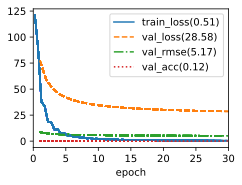

In [120]:
from mdl import torch as mdl
class MatrixFactorization(Regression):
    def __init__(self):
        super().__init__()
        self.hidden_dim = 128
        self.u_embed = nn.Embedding(1000, self.hidden_dim)
        self.i_embed = nn.Embedding(2000, self.hidden_dim)
        self.u_bias = nn.Embedding(1000, 1)
        self.i_bias = nn.Embedding(2000, 1)
    def forward(self, u, i):
        return (self.u_embed(u) * self.i_embed(i)).sum(axis=1) + self.u_bias(u).squeeze() + self.i_bias(i).squeeze()

mdl.Trainer(max_epochs=30, num_gpus=1).fit(MatrixFactorization(), Ml100kData(False, 16)) 

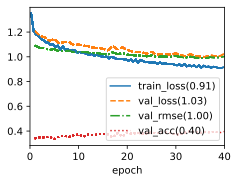

In [61]:
class NeuMF(Regression):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.save_hyperparameters()
        self.p_embed = nn.Embedding(1000, self.hidden_dim)
        self.q_embed = nn.Embedding(2000, self.hidden_dim)
        self.u_embed = nn.Embedding(1000, self.hidden_dim)
        self.v_embed = nn.Embedding(2000, self.hidden_dim)
        self.mlp = nn.Sequential(nn.LazyLinear(self.hidden_dim), nn.ReLU(),
                                 nn.LazyLinear(self.hidden_dim), nn.ReLU())
        self.output = nn.LazyLinear(1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, uid, iid):
        p = self.p_embed(uid)
        q = self.q_embed(iid)
        x = p * q
        u = self.u_embed(uid)
        v = self.v_embed(iid)
        z = self.mlp(torch.cat((u, v), dim=1))
        # return 6*self.sigmoid(self.output(torch.cat((x, z), dim=1))).squeeze()
        return (self.output(torch.cat((x, z), dim=1))).squeeze()
    
mdl.Trainer(max_epochs=40, num_gpus=1).fit(NeuMF(), Ml100kData(False, 32)) 

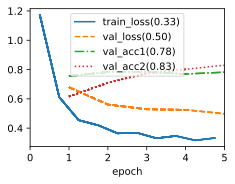

In [231]:
class MfSeqReco(Lable10Classifier):
    def __init__(self):
        super().__init__()
        self.hidden_dim = 16
        self.u_embed = nn.Embedding(1000, self.hidden_dim)
        self.i_embed = nn.Embedding(2000, self.hidden_dim)
        self.u_bias = nn.Embedding(1000, 1)
        self.i_bias = nn.Embedding(2000, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, uid, seq, ipos, ineg):
        y1 = self.sigmoid(self.dotprod(uid, ipos))
        y2 = self.sigmoid(self.dotprod(uid, ineg))
        return y1, y2
    def dotprod(self, uid, iid):
        return (self.u_embed(uid) * self.i_embed(iid)).sum(axis=1) + self.u_bias(uid).squeeze() + self.i_bias(iid).squeeze() 

mf_seq_reco_model = MfSeqReco()
mdl.Trainer(max_epochs=5, num_gpus=1).fit(mf_seq_reco_model, Ml100kData(True, 32)) 

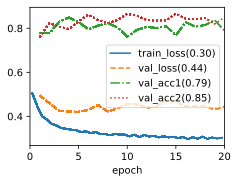

In [212]:
class AttentionSeqReco(Lable10Classifier):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.save_hyperparameters()
        self.hidden_dim = 16
        self.user_embed = nn.Embedding(1000, self.hidden_dim)
        nn.init.xavier_normal_(self.user_embed.weight)
        self.item_embed = nn.Embedding(2000, self.hidden_dim)
        nn.init.xavier_normal_(self.item_embed.weight)
        self.pos_enc = mdl.PositionalEncoding(self.hidden_dim, self.dropout)
        self.attention = nn.MultiheadAttention(self.hidden_dim, 2, batch_first=True, dropout=self.dropout)
        self.attention.apply(lambda mod: nn.init.xavier_normal_(mod.weight) if isinstance(mod, nn.Linear) else None)
        self.mlp = nn.Sequential(nn.Linear(self.hidden_dim*3, self.hidden_dim), nn.ReLU(), nn.Linear(self.hidden_dim, 1))
        self.mlp.apply(lambda mod: nn.init.xavier_normal_(mod.weight) if isinstance(mod, nn.Linear) else None)
    def forward(self, uid, seq, ipos, ineg):
        user_e = self.user_embed(uid)
        # seq_e = (self.item_embed(seq))
        seq_e = self.pos_enc(self.item_embed(seq))
        pos_item_e, neg_item_e = self.item_embed(ipos), self.item_embed(ineg)
        return self.network(user_e, seq_e, pos_item_e), self.network(user_e, seq_e, neg_item_e)
    def network(self, user_e, seq_e, target_e):
        long_interest_e = self.attention(target_e.unsqueeze(1), seq_e, seq_e)[0].squeeze(1)
        input_e = torch.cat((user_e, long_interest_e, target_e), dim=1)
        output = self.mlp(input_e).squeeze()
        return nn.functional.sigmoid(output)

mdl.Trainer(max_epochs=20, num_gpus=1).fit(AttentionSeqReco(), Ml100kData(True, 64)) 

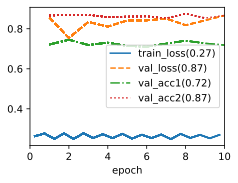

In [234]:
# 增量效果不明显，过拟合严重
class MfAttentionSeqReco(Lable10Classifier):
    def __init__(self, dropout=0.7):
        super().__init__()
        self.save_hyperparameters()
        self.mf = mf_seq_reco_model
        self.hidden_dim = 16
        self.user_embed = self.mf.u_embed
        self.item_embed = self.mf.i_embed
        # self.user_embed = nn.Embedding(1000, self.hidden_dim)
        # nn.init.xavier_normal_(self.user_embed.weight)
        # self.item_embed = nn.Embedding(2000, self.hidden_dim)
        # nn.init.xavier_normal_(self.item_embed.weight)
        self.pos_enc = mdl.PositionalEncoding(self.hidden_dim, self.dropout)
        self.attention = nn.MultiheadAttention(self.hidden_dim, 2, batch_first=True, dropout=self.dropout)
        self.attention.apply(lambda mod: nn.init.xavier_normal_(mod.weight) if isinstance(mod, nn.Linear) else None)
        self.mlp = nn.Sequential(nn.Linear(self.hidden_dim*3, self.hidden_dim), nn.ReLU(), nn.Linear(self.hidden_dim, 1))
        self.mlp.apply(lambda mod: nn.init.xavier_normal_(mod.weight) if isinstance(mod, nn.Linear) else None)
    def forward(self, uid, seq, ipos, ineg):
        user_e = self.user_embed(uid)
        # seq_e = (self.item_embed(seq))
        seq_e = self.pos_enc(self.item_embed(seq))
        pos_item_e, neg_item_e = self.item_embed(ipos), self.item_embed(ineg)
        return self.network(uid, ipos, user_e, seq_e, pos_item_e), self.network(uid, ineg, user_e, seq_e, neg_item_e)
    def network(self, uid, iid, user_e, seq_e, target_e):
        long_interest_e = self.attention(target_e.unsqueeze(1), seq_e, seq_e)[0].squeeze(1)
        input_e = torch.cat((user_e, long_interest_e, target_e), dim=1)
        mlp_output = self.mlp(input_e).squeeze()
        mf_output = self.mf.dotprod(uid, iid)
        return nn.functional.sigmoid(mlp_output + mf_output)

mdl.Trainer(max_epochs=10, num_gpus=1).fit(MfAttentionSeqReco(), Ml100kData(True, 64)) 